In [70]:
# AMP for signal recovery in compressed sensing.
# CS model: y = A * x + noise
# Goal: recover x given y and A
#
# This notebook compares the histograms of the effective observation 
# term s^t = x^t + A^T * z^t of the AMP algorithm and the iterative 
# soft-thresholding (IST) algorithm, where t is the iteration index.
# 
# The only difference between the AMP algorithm and the IST algorithm
# is that in the AMP algorithm there is the additional "Onsager"
# correction term in the calculation of the residual vector, 
# i.e., in IST we have z^t = y − A * x^t, whereas in AMP we have 
# z^t = y − A * x^t + b * z^{t-1}.
# 
# The role of the Onsager correction term is crucial for the 
# effectiveness of the AMP and its per-iteration error characterisation
# using state evolution. 
# The key intuition behind the AMP is that the entries of the effective
# observation s^t can be seen as the true signal x corrupted with
# zero-mean additive Gaussian noise. This is not true for the IST.
# Therefore, we expect the histogram of s^t of the AMP to look Gaussian
# centred around the true x, whereas the IST histogram should not look
# Gaussian.
# For more details on the intuition of the Onsager correction term,
# see Section I.C. of “The dynamics of message passing on dense graphs,
# with applications to compressed sensing" by Bayati and Montanari (2011)
#
# Specifically, in this notebook I replicate Figure 6 of "Graphical 
# Models Concepts in Compressed Sensing" by Andrea Montanari (2011),
# with minor modifications.
#
# The system setup is as follows:
# - The sensing matrix A has M=2000 rows and N=4000 columns and i.i.d. 
#   entries uniform in {+1/sqrt(M), -1/sqrt(M)}.
# - The signal x with dimension N=4000 has 500 non-zero entries
#   uniform in {+1,-1}.
# 
# I plot the distribution of (s^t)_i = (x^t + A^T * z^t)_i for 
# coordinates i such that the true signal has value x_i = +1 after 
# t = 10 iterations.
# A total of 40 instances of were used to build the histograms. Across
# instances, the same signal and sensing matrix was used, but a random
# noise vector was sampled in each instance. (This differs from the 
# setup in Fig. 6 of Montanari 2011. I also use a different 
# thresholding parameter alpha for AMP and IST.)
#
# For AMP (left), the distribution is close to Gaussian, with mean 
# close to the correct value, x_i = +1. 
# For IST (right), the distribution does not have the correct mean 
# and is not Gaussian.
#
# Copyright (c) 2021 Kuan Hsieh

import numpy as np
from numpy import linalg as LA
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import time

from amp4cs import initialise_CS, opt_tuning_param, soft_thresh

In [233]:
N = 4000  # dimension of signal
M = 2000  # of measurements
K = 500   # of non-zero coefficients
sigma = 0.1 # Noise standard deviation
alpha_amp = opt_tuning_param(K/N) # Find optimal alpha
alpha_ist = 2.0 # Find optimal alpha, this needs to be optimised empirically
iter_max  = 10 # The iteration number to analyse signal estimate distribution

numOfRuns = 40

#######

start = time.perf_counter()

# Generate signal
x_init = 1*(np.random.rand(K)<0.5)
x_init[np.logical_not(x_init)] = -1
x_init = np.concatenate((x_init, np.zeros((N-K))))
np.random.shuffle(x_init)

idxs      = np.array(x_init==1)           # Indices of +1 entries
numOf1s   = np.count_nonzero(idxs)        # Number of +1 entries
s_err_amp = np.zeros((numOfRuns,numOf1s)) # Store effective observations at +1
s_err_ist = np.zeros((numOfRuns,numOf1s)) # entry locations after 10 iterations

# Generate sensing matrix
A = np.random.randn(M,N)/np.sqrt(M)

# Generate noiseless measurements
Ax_init = np.dot(A,x_init)
    
for run in range(numOfRuns):

    # Generate random noise and add to measurements
    y = Ax_init + sigma*np.random.randn(M)
    
    # Run decoders
    x_amp = np.zeros_like(x_init) # Initial signal estimate
    x_ist = np.zeros_like(x_init)
    z_amp = y                     # Initial residual
    z_ist = y

    for t in range(iter_max):

        # AMP estimate vector
        theta = alpha_amp * np.sqrt(LA.norm(z_amp)**2/M) # alpha*tau
        s_amp = x_amp + np.dot(A.T,z_amp)
        x_amp = soft_thresh(s_amp, theta)

        # IST estimate vector
        theta = alpha_ist * np.sqrt(LA.norm(z_ist)**2/M) # alpha*tau
        s_ist = x_ist + np.dot(A.T,z_ist)
        x_ist = soft_thresh(s_ist, theta)

        # AMP calculate residual with the Onsager term
        b     = LA.norm(x_amp,0)/M
        z_amp = y - np.dot(A,x_amp) + b*z_amp

        # IST calculate residual without Onsager term
        z_ist = y - np.dot(A,x_ist)
    
    s_err_amp[run] = s_amp[idxs]
    s_err_ist[run] = s_ist[idxs]

print('time elapsed (s):', time.perf_counter() - start)

time elapsed (s): 4.802351339996676


AMP: mu = 0.9891002623111383, tau^2 = 0.05712686379014464
IST: mu = 0.7657341600233943, tau^2 = 0.14043736083650363


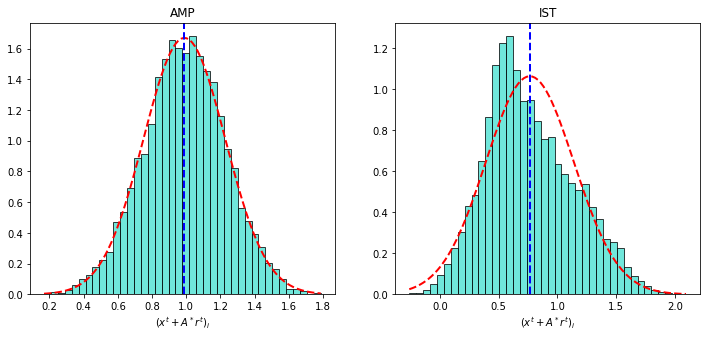

In [237]:
numOfBins = 40
plt.figure(figsize=(12,5))
plt.subplot(121)
_= plt.hist(s_err_amp.flatten(),bins=numOfBins,density=1,color='turquoise',edgecolor='k',alpha=0.75)
# Stack fitted normal distribution on top
min_amp = s_err_amp.min()
max_amp = s_err_amp.max()
(mu_amp, tau_amp) = norm.fit(s_err_amp)
y = norm.pdf(np.linspace(min_amp,max_amp,100), mu_amp, tau_amp)
plt.plot(np.linspace(min_amp,max_amp,100), y, 'r--', linewidth=2)
plt.axvline(mu_amp, color='b', linestyle='--', linewidth=2)
plt.title('AMP')
plt.xlabel(r'$(x^t+A^*r^t)_i$')
# plt.axis([-1,1,0,1.6])
print('AMP: mu = {}, tau^2 = {}'.format(mu_amp, tau_amp**2))

plt.subplot(122)
_= plt.hist(s_err_ist.flatten(),bins=numOfBins,density=1,color='turquoise',edgecolor='k',alpha=0.75)
# Stack fitted normal distribution on top
min_ist = s_err_ist.min()
max_ist = s_err_ist.max()
(mu_ist, tau_ist) = norm.fit(s_err_ist)
y = norm.pdf(np.linspace(min_ist,max_ist,100), mu_ist, tau_ist)
plt.plot(np.linspace(min_ist,max_ist,100), y, 'r--', linewidth=2)
plt.axvline(mu_ist, color='b', linestyle='--', linewidth=2)
plt.title('IST')
plt.xlabel(r'$(x^t+A^*r^t)_i$')
# plt.axis([0,2,0,1.8])
print('IST: mu = {}, tau^2 = {}'.format(mu_ist, tau_ist**2))